# Regression on Gdelt News

This notebook would use Li2CO3 data from investing.com (which totally have data from 2018 to 2023) and the unit is CNY/TON. 

Gdelt News Data: 
https://colab.research.google.com/drive/1QLkUWxfa9wMMjdii9O_0yTiBJwo9eFXG#scrollTo=G8jOUfqU36vB

In [48]:
import warnings 
warnings.filterwarnings('ignore')
from utils.utils import transform_data, plot_correlogram, get_stock_data
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.tsa.arima.model as tsa

In [4]:
help(transform_data)

Help on function transform_data in module utils.utils:

transform_data(file_path, sampling_period='W-FRI')
    This function transform the price into log return and output the weekly log return and price in a dataframe.



In [42]:
li2co3 = transform_data("../data/Lithium Carbonate 99%Min China Spot Historical Data2.csv", sampling_period='W-FRI')

         Date       Price        Open        High         Low  Vol. Change %
0  11/10/2023  144,500.00  144,500.00  147,000.00  142,000.00   NaN   -2.03%
1  11/09/2023  147,500.00  147,500.00  150,000.00  145,000.00   NaN    0.00%
2  11/08/2023  147,500.00  147,500.00  150,000.00  145,000.00   NaN   -1.34%
3  11/07/2023  149,500.00  149,500.00  152,000.00  147,000.00   NaN   -2.61%
4  11/06/2023  153,500.00  153,500.00  156,000.00  151,000.00   NaN   -0.65%


Please enter the column names, separated by a comma:  Date, Price, 1, 2, 3, 4, 5


<AxesSubplot: xlabel='Date'>

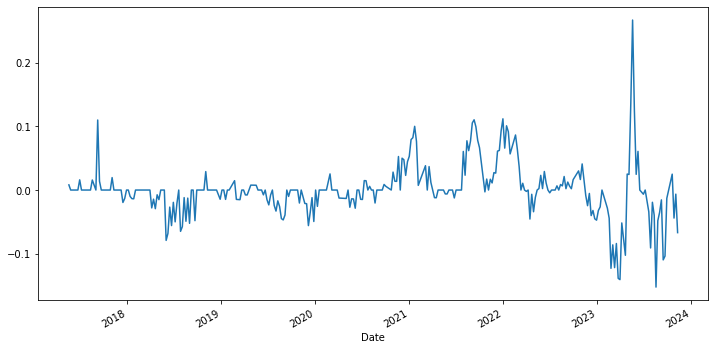

In [43]:
# Specify the size of the figure
plt.figure(figsize=(12, 6))
li2co3.Log_Return.plot()

In [45]:
# ro is observed data
ro = li2co3.Log_Return

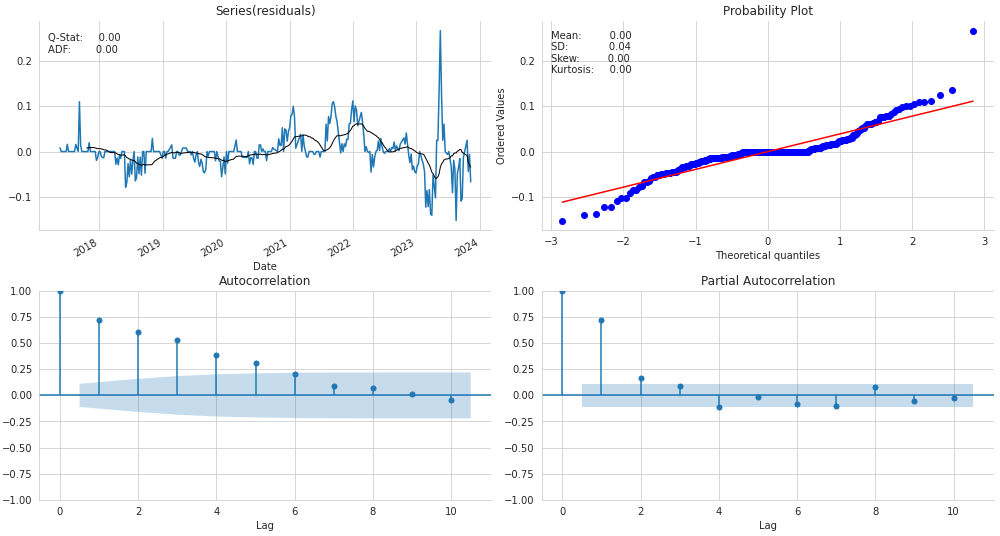

In [46]:
plot_correlogram(ro)

## MA(q = 3) 

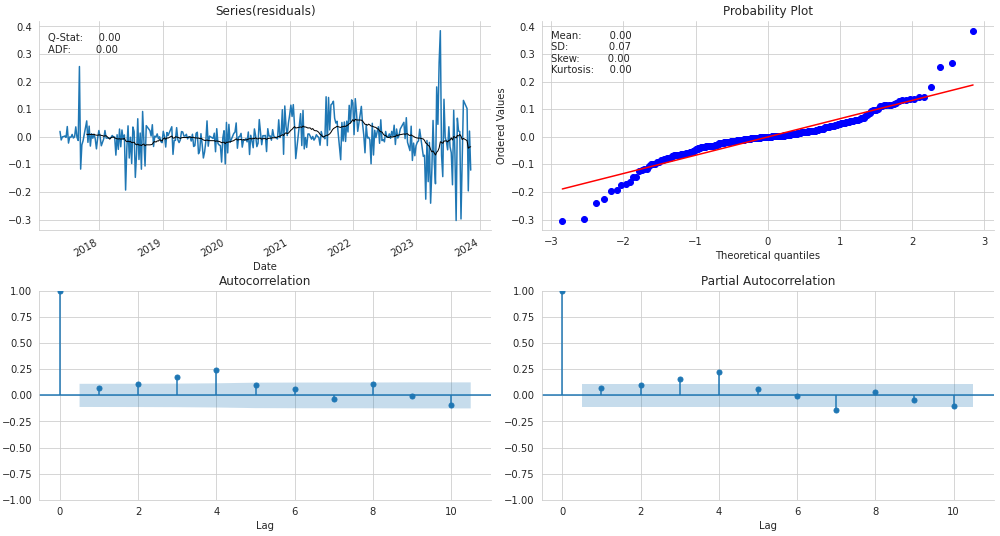

In [139]:
MA_3_result = model_price = tsa.ARIMA(ro,order=(0,0,3)).fit()

mu, theta1, theta2, theta3, std = MA_3_result.params

residual = MA_3_result.resid
fitted_3 = mu + (1+theta1+theta2+theta3) * residual

plot_correlogram(fitted_3)

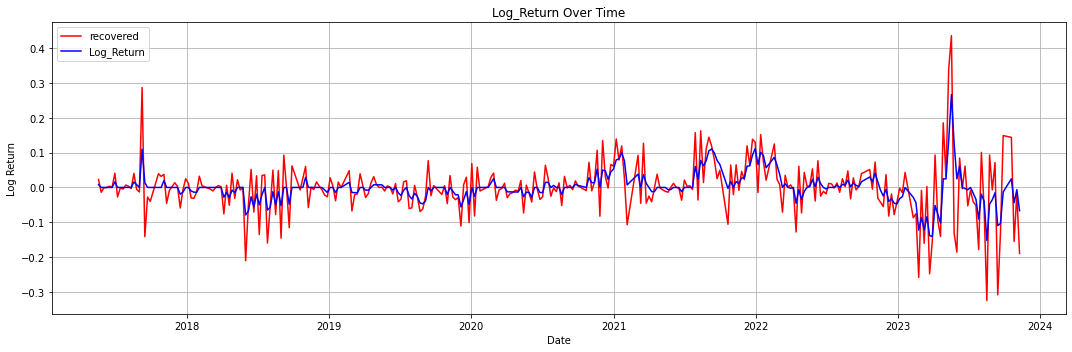

In [140]:
# plot fitted and original one: 

# Separate plot for 'Log_Return' for clarity and because it might be on a different scale
plt.figure(figsize=(15, 5))
plt.plot(ro.index, fitted_4, label="recovered", color="red")
plt.plot(ro.index, ro, label="Log_Return", color="blue")
plt.title("Log_Return Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

## Regression on Gdelt

In [93]:
import pandas as pd
gdelt_news = pd.read_csv('../data/gdelt_week_friday.csv')

In [141]:
gdelt_news.week_friday = pd.to_datetime(gdelt_news.week_friday)

df_ro = pd.DataFrame(fitted_3)
df_ro.columns = ['Log_Return']
df_reg_on_gdelt = gdelt_news.merge(df_ro, left_on = 'week_friday', right_on = 'Date', how = 'inner')

In [142]:
df_reg_on_gdelt = df_reg_on_gdelt.dropna()

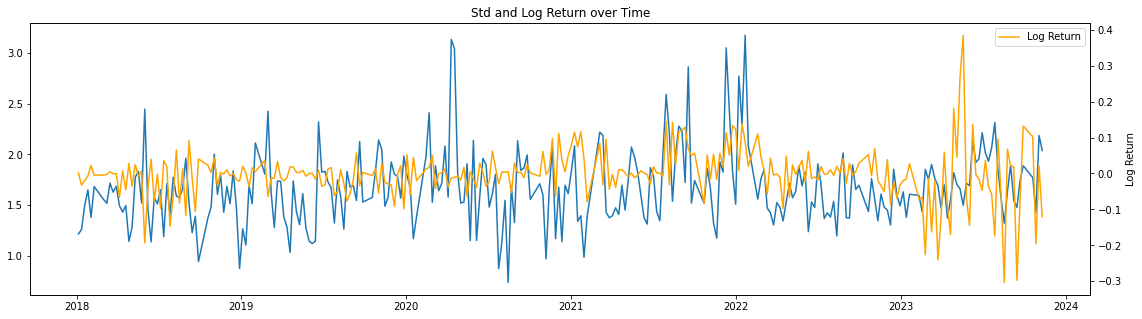

In [143]:
import matplotlib.pyplot as plt

# Assuming df_reg_on_gdelt is your DataFrame and it has 'week_friday', 'max', and 'Log_Return' columns

plt.figure(figsize=(19, 5))

# Plot the first line with 'max' on the left y-axis
plt.plot(df_reg_on_gdelt['week_friday'], df_reg_on_gdelt['std'], label='sdt')

# Create a second y-axis that shares the same x-axis
ax2 = plt.twinx()

# Plot the second line with 'Log_Return' on the right y-axis
ax2.plot(df_reg_on_gdelt['week_friday'], df_reg_on_gdelt['Log_Return'], label='Log Return', color='orange')

# Optionally, add labels, title, and legend
plt.title('Std and Log Return over Time')
plt.xlabel('Date')
plt.ylabel('Max')
ax2.set_ylabel('Log Return')

# Adding legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [144]:
import numpy as np
df_reg_on_gdelt['count_diff'] = df_reg_on_gdelt['count'].diff()
df_reg_on_gdelt['count_log'] = np.log(df_reg_on_gdelt['count'])
df_reg_on_gdelt['max_diff'] = df_reg_on_gdelt['max'].diff()
df_reg_on_gdelt['min_diff'] = df_reg_on_gdelt['min'].diff()
df_reg_on_gdelt['std_diff'] = df_reg_on_gdelt['std'].diff()
df_reg_on_gdelt['max_min_diff'] = df_reg_on_gdelt['max'] - df_reg_on_gdelt['min'] 
df_reg_on_gdelt = df_reg_on_gdelt.dropna().reset_index(drop = True)

In [145]:
df_reg_on_gdelt.iloc[0:240, :]

,week_friday,count,mean,max,min,std,Log_Return,count_diff,count_log,max_diff,min_diff,std_diff,max_min_diff
0,2018-01-12,153,0.540838,5.479452,-3.154574,1.259208,-0.032480,97.0,5.030438,1.939629,-1.956417,0.044567,8.634026
1,2018-01-19,145,0.535426,4.000000,-6.727829,1.498560,-0.019725,-8.0,4.976734,-1.479452,-3.573255,0.239352,10.727829
2,2018-01-26,154,0.939129,9.049774,-4.878049,1.648920,-0.007243,9.0,5.036953,5.049774,1.849780,0.150361,13.927823
3,2018-02-02,143,0.778991,4.735376,-2.923977,1.378502,0.022775,-11.0,4.962845,-4.314398,1.954072,-0.270418,7.659353
4,2018-02-09,132,0.847501,5.600000,-3.178484,1.682546,-0.004701,-11.0,4.882802,0.864624,-0.254507,0.304044,8.778484
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-12-09,247,0.464877,5.102041,-3.502825,1.302845,-0.085751,6.0,5.509388,-1.419698,0.564161,-0.148354,8.604866
236,2022-12-16,194,0.476727,5.917160,-4.662005,1.853782,-0.022810,-53.0,5.267858,0.815119,-1.159180,0.550937,10.579164
237,2022-12-23,193,0.699477,4.672897,-5.172414,1.600836,-0.068580,-1.0,5.262690,-1.244263,-0.510409,-0.252946,9.845311
238,2022-12-30,99,0.033874,4.487179,-3.778040,1.491420,-0.032336,-94.0,4.595120,-0.185718,1.394374,-0.109416,8.265220


In [131]:
y_train = df_reg_on_gdelt['Log_Return'][100:280]
y_train

100    0.000000
101    0.012903
102    0.025318
103    0.000000
104    0.000000
         ...   
275   -0.103752
276   -0.012945
277    0.024923
278   -0.044032
279   -0.006452
Name: Log_Return, Length: 180, dtype: float64

In [129]:
X_train = df_reg_on_gdelt[['count', 'mean', 'min', 'max', 'std']].iloc[100:280, :]
X_train

,count,mean,min,max,std
100,120,-0.436480,-5.714286,9.644670,1.978903
101,50,-0.501869,-7.500000,7.971014,2.410505
102,71,1.008699,-3.454545,4.444444,1.527470
103,43,0.477269,-4.285714,4.793864,1.887651
104,71,0.830462,-1.605351,5.626134,1.641149
...,...,...,...,...,...
275,265,0.533256,-4.400000,7.407407,1.741138
276,405,0.536894,-8.035714,6.779661,1.888982
277,264,0.637306,-3.771290,5.354331,1.771544
278,288,0.733813,-4.597701,6.226054,1.426142


In [135]:
X_train_scaled

,count,mean,min,max,std
0,-0.352524,-1.834426,-0.597271,2.205181,0.683212
1,-0.987340,-1.959765,-1.538818,1.317241,1.794682
2,-0.796895,0.935732,0.594215,-0.553743,-0.479328
3,-1.050821,-0.082929,0.155967,-0.368362,0.448218
4,-0.796895,0.594082,1.569233,0.073190,-0.186581
...,...,...,...,...,...
175,0.962451,0.024390,0.095708,1.018225,0.070913
176,2.232082,0.031363,-1.821282,0.685181,0.451644
177,0.953382,0.223835,0.427206,-0.071013,0.149216
178,1.171033,0.408821,-0.008533,0.391471,-0.740269


## Simple Linear Regression 

In [146]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

X_train = df_reg_on_gdelt[['count', 'mean', 'min', 'max', 'std']].iloc[0:240, :]
y_train = np.array(df_reg_on_gdelt['Log_Return'][0:240])

X_test = df_reg_on_gdelt[['count', 'mean', 'min', 'max', 'std']].iloc[200:, :]
y_test = df_reg_on_gdelt['Log_Return'][200:]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

import statsmodels.api as sm

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)

#X_train_scaled_sm = sm.add_constant(X_train_scaled)

# Create a model
model_sm = sm.OLS(y_train, X_train_scaled)

# Fit the model
results = model_sm.fit()

# Get the summary of the regression
summary = results.summary()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.051
Model:                            OLS   Adj. R-squared (uncentered):              0.031
Method:                 Least Squares   F-statistic:                              2.516
Date:                Fri, 10 Nov 2023   Prob (F-statistic):                      0.0305
Time:                        18:34:03   Log-Likelihood:                          383.09
No. Observations:                 240   AIC:                                     -756.2
Df Residuals:                     235   BIC:                                     -738.8
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [33]:
# Add a constant to the scaled test data
#X_test_scaled_sm = sm.add_constant(X_test_scaled)

# Use the trained model to make predictions on the scaled test data
y_test_pred = results.predict(X_test_scaled)

# Calculate the actual direction of change
actual_changes = np.sign(np.diff(y_test))

# Calculate the predicted direction of change
predicted_changes = np.sign(np.diff(y_test_pred))

# Calculate the hit rate
hits = np.sum(actual_changes == predicted_changes)
total_predictions = len(actual_changes)

# Hit rate
hit_rate = hits / total_predictions

hit_rate

0.4533333333333333

## Adding Polynomial Terms

In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction_scaled = poly.fit_transform(X_train_scaled)
# Get the names of the features created
interaction_feature_names = poly.get_feature_names(X_train.columns)

X_train_interaction_scaled = pd.DataFrame(X_train_interaction_scaled, columns = interaction_feature_names)

X_train_interaction_scaled_sm = sm.add_constant(X_train_interaction_scaled)

model_interaction_sm = sm.OLS(y_train, X_train_interaction_scaled_sm)

results_interaction = model_interaction_sm.fit()

summary_interaction = results_interaction.summary()
print(summary_interaction)


                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     3.943
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           3.80e-06
Time:                        01:26:17   Log-Likelihood:                 417.97
No. Observations:                 200   AIC:                            -803.9
Df Residuals:                     184   BIC:                            -751.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.003      1.627      0.1

In [35]:
# First, we will transform the test data using the same PolynomialFeatures and scaler as the training data
X_test_interaction = poly.transform(X_test)
X_test_interaction_scaled = scaler_interaction.transform(X_test_interaction)
X_test_interaction_scaled_df = pd.DataFrame(X_test_interaction_scaled, columns=interaction_feature_names)

# Add a constant to the scaled test data
X_test_interaction_scaled_sm = sm.add_constant(X_test_interaction_scaled_df)

# Use the trained model to make predictions on the scaled test data
y_test_pred = results_interaction.predict(X_test_interaction_scaled_sm)

# Assume y_test contains the actual returns and y_test_pred contains the predicted returns
# Calculate the actual direction of change
actual_direction = np.sign(y_test - y_test.shift(1))

# Calculate the predicted direction of change
predicted_direction = np.sign(y_test_pred - y_test.shift(1))

# Remove the first element since it will be NaN after the shift
actual_direction = actual_direction[1:]
predicted_direction = predicted_direction[1:]

# Calculate the number of correct predictions
print('act', actual_direction)
print('pre', predicted_direction)
correct_predictions = np.sum(actual_direction == predicted_direction)

# Calculate the hit rate
hit_rate = correct_predictions / len(actual_direction)

hit_rate



act 201   -1.0
202    1.0
203   -1.0
204    1.0
205    1.0
      ... 
271   -1.0
272    1.0
273    1.0
274    1.0
275   -1.0
Name: Log_Return, Length: 75, dtype: float64
pre 1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
       ..
271   NaN
272   NaN
273   NaN
274   NaN
275   NaN
Length: 151, dtype: float64


ValueError: Can only compare identically-labeled Series objects

In [36]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_interaction_scaled = poly.fit_transform(X_train_scaled)
# Get the names of the features created
interaction_feature_names = poly.get_feature_names(X_train.columns)

X_train_interaction_scaled = pd.DataFrame(X_train_interaction_scaled, columns = interaction_feature_names)

X_train_interaction_scaled_sm = sm.add_constant(X_train_interaction_scaled)

model_interaction_sm = sm.OLS(y_train, X_train_interaction_scaled_sm)

results_interaction = model_interaction_sm.fit()

summary_interaction = results_interaction.summary()
print(summary_interaction)


                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     3.091
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           3.24e-05
Time:                        01:26:55   Log-Likelihood:                 419.77
No. Observations:                 200   AIC:                            -797.5
Df Residuals:                     179   BIC:                            -728.3
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.004      1.123      0.2

In [80]:
y_pred

0     0.130889
1     0.127845
2     0.033952
3     0.018186
4     0.125164
        ...   
70   -0.025479
71    0.029946
72    0.004725
73   -0.002587
74    0.043625
Length: 75, dtype: float64

In [79]:
y_test.shift(1)

200         NaN
201   -0.045561
202   -0.006682
203   -0.034094
204   -0.011628
         ...   
270   -0.015464
271   -0.109699
272   -0.103752
273   -0.012945
274    0.024923
Name: Log_Return, Length: 75, dtype: float64

In [74]:
# To evaluate the model, we'll first need to transform the test data in the same way we did the training data
# Create the squared terms and interaction terms for the test set
X_test_poly = poly.transform(X_test_scaled)

# Convert to a DataFrame with the appropriate feature names
X_test_poly_df = pd.DataFrame(X_test_poly)

# Add a constant to the DataFrame for the intercept
X_test_poly_with_constant = sm.add_constant(X_test_poly_df)

# Use the fitted model to make predictions on the test set
y_pred = results_interaction.predict(X_test_poly_with_constant)
print(y_pred)
# Assume y_test contains the actual returns and y_test_pred contains the predicted returns
# Calculate the actual direction of change
actual_direction = np.sign(y_test - y_test.shift(1))

# Calculate the predicted direction of change
predicted_direction = np.sign(y_pred - y_test.shift(1))
print(predicted_direction)

# Remove the first element since it will be NaN after the shift
actual_direction = actual_direction[1:]
predicted_direction = predicted_direction[1:]

# Calculate the number of correct predictions
correct_predictions = np.sum(actual_direction == predicted_direction)

# Calculate the hit rate
hit_rate = correct_predictions / len(actual_direction)

hit_rate


0     0.130889
1     0.127845
2     0.033952
3     0.018186
4     0.125164
        ...   
70   -0.025479
71    0.029946
72    0.004725
73   -0.002587
74    0.043625
Length: 75, dtype: float64
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
270   NaN
271   NaN
272   NaN
273   NaN
274   NaN
Length: 150, dtype: float64


ValueError: Can only compare identically-labeled Series objects